# **Modelo de Clasificación para Customer Churn**

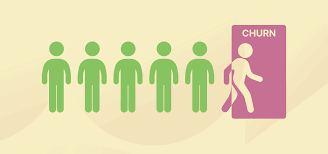

In [1]:
!pip install catboost --quiet
!pip install shap --quiet #==0.44.1
#!pip install numpy==1.26.4
!pip install feature-engine --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 4.8 MB/s eta 0:00:00


Instalación e importanción de las bibliotecas necesarias

In [4]:
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier

In [2]:
import shap
shap.initjs()

Se descarga el archivo CSV con los datos de Internet (o de Drive)

In [5]:
# https://www.kaggle.com/code/jsaguiar/churn-prediction-tutorial-with-sklearn

# https://drive.google.com/file/d/1YSqScvVqUFz2xDrnDK7PyfalimMJ92-X/view?usp=sharing
URL = "https://drive.google.com/uc?export=download&id=1YSqScvVqUFz2xDrnDK7PyfalimMJ92-X"
DATAPATH = 'customer_churn_kaggle.csv'

print(gdown.download(URL, DATAPATH, quiet=True))

customer_churn_kaggle.csv


Se carga el CSV en un dataframe

In [6]:
df = pd.read_csv(DATAPATH)
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


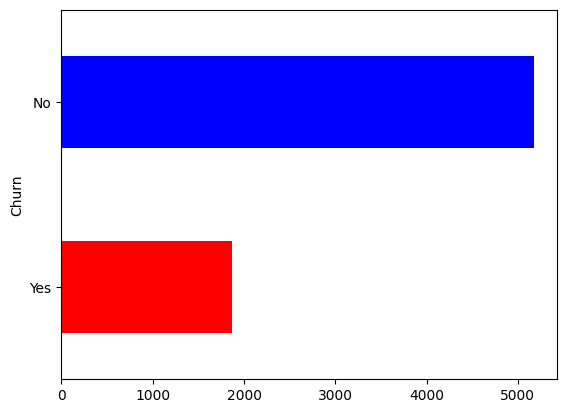

In [8]:
# Miramos la relación entre instancias positivas y negativas
df['Churn'].value_counts().sort_values().plot(kind = 'barh', color=['red', 'blue'])
plt.show()

Preprocesamiento básico de los datos

In [9]:
# Replace churn column by 0 or 1
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})

# Inpute missing values
df['TotalCharges'] = df['TotalCharges'].replace(" ", 0).astype('float32')

# Get categorical columns (except the target)
categorical_cols = [c for c in df.columns if df[c].dtype == 'object' or c == 'SeniorCitizen'] # categorical data
categorical_cols

/tmp/ipython-input-369144463.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})


['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

## **Seleccion de Features (opcional)**

https://feature-engine.trainindata.com/en/latest/api_doc/selection/index.html#

In [10]:
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.selection import MRMR


In [14]:
X = df.copy().drop('Churn', axis=1)

# Probamos con eliminar features quasi-constantes (por ej., que tengan el mismo valor el 90% de las veces)
dcf = DropConstantFeatures(tol=0.9)
X1 = dcf.fit_transform(X)
print("Before:", X.shape)
print("After:", X1.shape)

Before: (7043, 20)
After: (7043, 19)


In [17]:
X = df.copy().drop(categorical_cols+['Churn'], axis=1) # Solo funciona con features numericas

# Mira correlaciones por grupos y luego selecciona un feature de cada grupo
scs = SmartCorrelatedSelection(threshold=0.7)
X1 = scs.fit_transform(X)
print("Before:", X.shape)
print("After:", X1.shape)

Before: (7043, 3)
After: (7043, 2)


In [33]:
# X = df.copy().drop(categorical_cols+['Churn'], axis=1) # Solo funciona con features numericas
X = df.copy().drop(['Churn'], axis=1) # Solo funciona con features numericas
y = df.copy()['Churn']

mrmr_sel = MRMR(method="MID", random_state=3)
X1 = mrmr_sel.fit_transform(X, y)
print("Before:", X.shape)
print("After:", X1.shape)

Before: (7043, 20)
After: (7043, 18)


## **Algoritmo de Regresion Logistica (baseline)**

In [ ]:
scaler = StandardScaler()

X = df.drop(categorical_cols+['Churn'], axis=1)
X = scaler.fit_transform(X) # Standardization
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Se crea y entrena el modelo Logistic Regression
lr = LogisticRegression(solver='liblinear', random_state=42)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

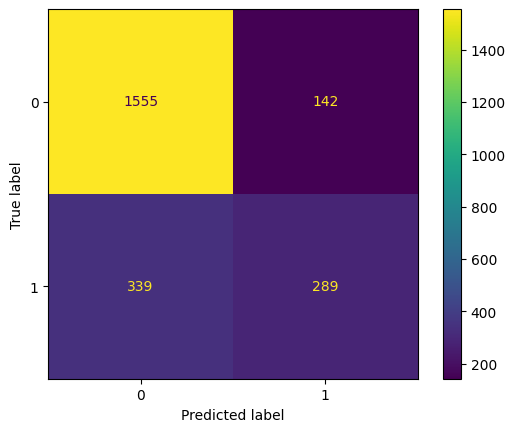

In [ ]:
# Se testea el modelo
cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()
plt.show()

In [ ]:
# Precision
precision = precision_score(y_test, y_pred)
# Recall
recall = recall_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.6705336426914154
Recall: 0.4601910828025478


## **Algoritmo CatBoost**

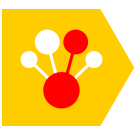

Separación entre datos de entrenamiento y datos de testeo

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Se entrena el modelo
model = CatBoostClassifier(random_seed=3, cat_features=categorical_cols)
model.fit(X_train, y_train, silent=True)

y_pred = model.predict(X_test)

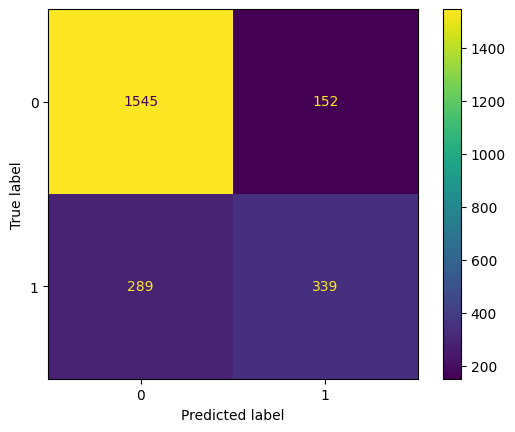

In [ ]:
# Se testea el modelo
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [ ]:
# Precision
precision = precision_score(y_test, y_pred)
# Recall
recall = recall_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.6904276985743381
Recall: 0.5398089171974523


In [ ]:
# Save the model
model_path = "classification_catboost_model.cbm"
model.save_model(model_path)

**Extra**: Interpretación del modelo para identificar los factores mas importantes en la clasificacion.

In [ ]:
X_sampled = X_test # X.sample(100, random_state=10)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sampled)

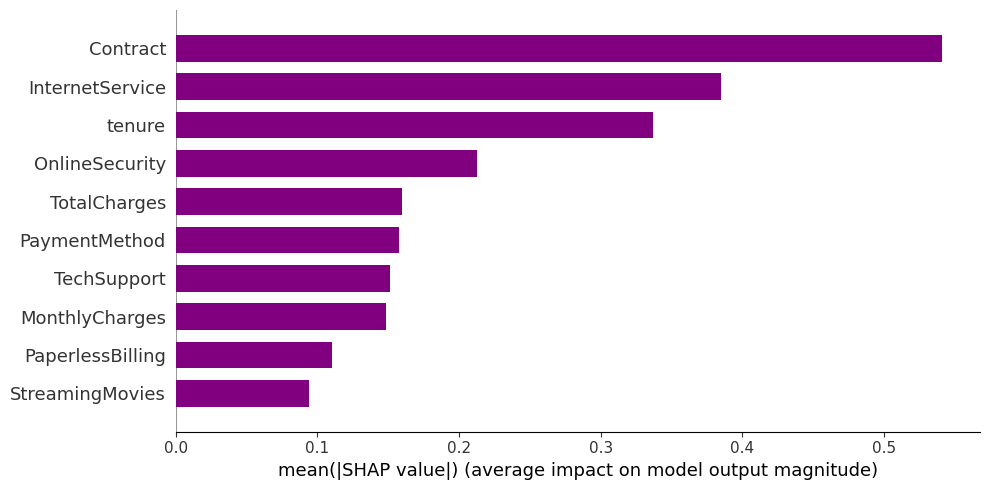

In [ ]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar", max_display=10, plot_size=(10,5), color='purple')

In [ ]:
# Load the model

loaded_model = CatBoostClassifier()
loaded_model.load_model(model_path)

y_pred = loaded_model.predict(X_test)
y_pred

array([1, 0, 0, ..., 1, 0, 0])

---